# Linear assignment problem

The [linear assignment problem](https://en.wikipedia.org/wiki/Linear_assignment_problem) is a fundamental problem in combinatorial optimization.

In this problem, we are given an $n \times m$ cost matrix.
The goal is to compute an assignment, i.e. a set of pairs of rows and columns, in such a way that:
- At most one column is assigned to each row.
- At most one row is assigned to each column.
- The total number of assignments is $\min(n, m)$.
- The assignment minimizes the sum of costs.

Equivalently, given a weighted complete bipartite graph, the problem is to find a maximum-cardinality matching that minimizes the sum of the weights of the edges included in the matching.

Formally, the problem is as follows. Given $C \in \mathbb{R}^{n \times m}$, solve the following [integer linear program](https://en.wikipedia.org/wiki/Integer_linear_program):

$$
\begin{align*}
    \text{minimize} \quad & \sum_{i \in [n]} \sum_{j \in [m]} C_{ij} X_{ij} \\
    \text{subject to} \quad
    & X_{ij} \in \{0, 1\} & \forall i \in [n], j \in [m] \\
    & \sum_{i \in [n]} X_{ij} \leq 1 & \forall j \in [m] \\
    & \sum_{j \in [m]} X_{ij} \leq 1 & \forall i \in [n] \\
    & \sum_{i \in [n]} \sum_{j \in [m]} X_{ij} = \min(n, m)
\end{align*}
$$

The [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) is a cubic-time algorithm for this problem.

First, we install [NetworkX](https://networkx.org/), a Python library that lets us draw graphs.
You can do this by running the following command on your terminal:
```
pip install -U networkx
```
Next, we import the libraries we will use:

In [1]:
import networkx as nx
from jax import random
import optax
from matplotlib import pyplot as plt

We sample a random cost matrix:

In [2]:
n = 5  # number of rows
m = 3  # number of columns

key = random.key(0)
costs = random.normal(key, (n, m))
print(costs)

[[ 0.08482574  1.9097648   0.29561743]
 [ 1.120948    0.33432344 -0.82606775]
 [ 0.6481277  -1.0353061  -0.7824839 ]
 [-0.4539462   0.6297971   0.81524646]
 [-0.32787678 -1.1234448  -1.6607416 ]]


We can visualize the cost matrix as follows:

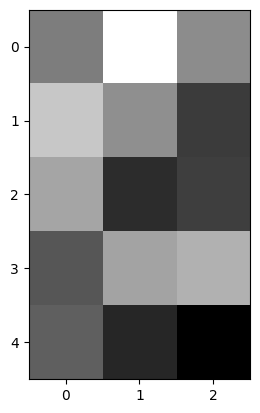

In [3]:
plt.imshow(costs, cmap="gray");

We can also visualize the costs as a weighted bipartite graph. Below, rows are shown as nodes the left and columns are shown as nodes the right.

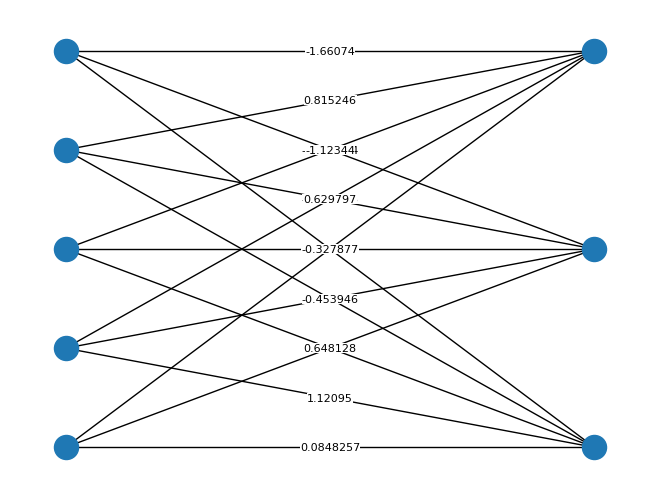

In [4]:
G = nx.Graph()
rows = [f"row {i}" for i in range(n)]
cols = [f"col {j}" for j in range(m)]
edges = [(rows[i], cols[j], {"cost": costs[i, j]}) for i in range(n) for j in range(m)]
G.add_nodes_from(rows + cols)
G.add_edges_from(edges)
layout = nx.bipartite_layout(G, rows)
nx.draw(G, layout)
nx.draw_networkx_edge_labels(
    G,
    layout,
    edge_labels={(u, v): f"{info["cost"]:g}" for u, v, info in edges},
    rotate=False,
    font_size=8,
    bbox=dict(
        pad=0.0,
        facecolor="white",
        edgecolor="none",
    ),
);

To solve the problem, we call {py:func}`optax.assignment.hungarian_algorithm` on the cost matrix.

In [5]:
sol_i, sol_j = optax.assignment.hungarian_algorithm(costs)
print(sol_i, sol_j)

[2 3 4] [1 0 2]


We can visualize the solution as follows:

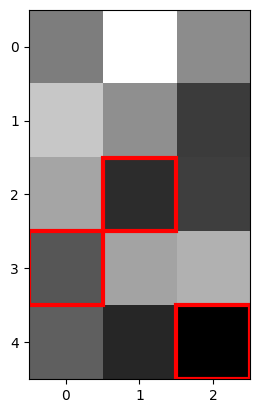

In [6]:
def highlight_cell(x, y, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, **kwargs)
    plt.gca().add_patch(rect)
    return rect

plt.imshow(costs, cmap="gray")

for i, j in zip(sol_i, sol_j):
    highlight_cell(j, i, color="red", linewidth=3)

plt.show()

We can also visualize the solution by drawing it on top of the previous bipartite graph. Below, nodes and edges that are included in the solution are shown in red.

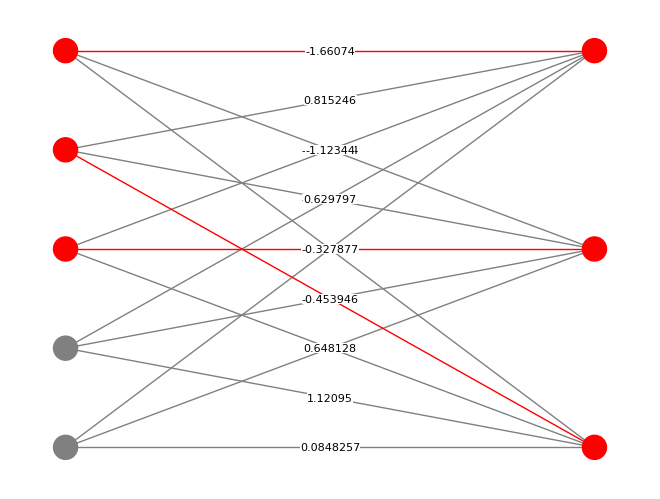

In [7]:
nx.draw(
    G,
    layout,
    node_color=["red" if i in sol_i else "grey" for i in range(n)] + ["red" if j in sol_j else "grey" for j in range(m)],
    edge_color=["red" if (i, j) in zip(sol_i, sol_j) else "grey" for i in range(n) for j in range(m)],
)
nx.draw_networkx_edge_labels(
    G,
    layout,
    edge_labels={(u, v): f"{info["cost"]:g}" for u, v, info in edges},
    rotate=False,
    font_size=8,
    bbox=dict(
        pad=0.0,
        facecolor="white",
        edgecolor="none",
    ),
);

# Optimal transport

A linear assignment solver can be used to solve an [optimal transport](https://en.wikipedia.org/wiki/Optimal_transport) problem: Given a [multiset](https://en.wikipedia.org/wiki/Multiset) of points $X \in \mathbb{R}^{n \times d}$ and another multiset of points $Y \in \mathbb{R}^{n \times d}$, find a [permutation](https://en.wikipedia.org/wiki/Permutation) $\pi \in \text{Sym}(n)$ between them that minimizes the total transportation cost:

$$ C(\pi) = \sum_{i \in [n]} d(X_i, Y_{\pi(i)}) $$

where $d$ is a [metric](https://en.wikipedia.org/wiki/Metric_space), such as the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) on $\mathbb{R}^d$.

Below is an illustrated example where $X$ is a set of _facility locations_ and $Y$ is a set of _client locations_ that must be matched to each other.

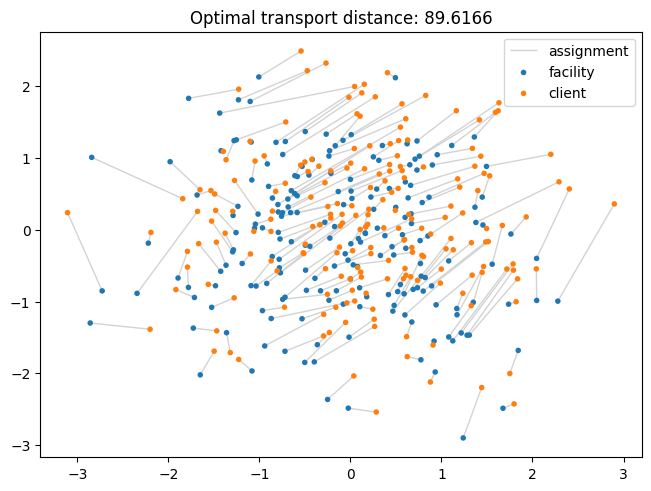

In [29]:
import jax
import optax
from jax import numpy as jnp, random
from matplotlib import collections, pyplot as plt, rcParams

def get_optimal_transport(x, y):
    assert x.ndim == 2
    assert x.shape == y.shape
    displacements = x[:, None] - y[None, :]
    distance_matrix = jnp.linalg.norm(displacements, axis=-1)
    i, j = optax.assignment.hungarian_algorithm(distance_matrix)
    total_distance = distance_matrix[i, j].sum()
    return (i, j), total_distance

def main():
    num_points = 200
    markersize = 16.0
    
    key = random.key(0)
    keys = random.split(key)
    x = random.normal(keys[0], (num_points, 2))
    y = random.normal(keys[1], (num_points, 2)) + jnp.array([0.2, 0.0])

    (i, j), total_distance = get_optimal_transport(x, y)

    fig, ax = plt.subplots(constrained_layout=True)
    
    data = jnp.stack((x[i], y[j]), 1)
    lc = collections.LineCollection(data, linewidth=1.0, color="lightgrey", zorder=0, label="assignment")
    ax.add_collection(lc)

    ax.scatter(*x.T, s=markersize, edgecolor="none", label="facility")
    ax.scatter(*y.T, s=markersize, edgecolor="none", label="client")

    ax.set(title=f"Optimal transport distance: {total_distance:g}")
    ax.legend()
    plt.show()

main()

This, in turn, can be used to estimate the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric#Higher_dimensions) between two distributions, by sampling a large batch of points from each and then computing the optimal transport cost between those batches.

More precisely, if $W_p$ denotes the $p$-Wasserstein distance and $P$ and $Q$ are [empirical distributions](https://en.wikipedia.org/wiki/Empirical_measure) with samples $X$ and $Y$, respectively, then:

$$ W_p(P, Q) = \inf_{\pi \in \text{Sym}(n)} \left( \frac{1}{n} \sum_{i=1}^n \|X_i - Y_{\pi(i)}\|^p \right)^{1/p} $$